# EcoFOCIpy SUNA QC or Filter example (seperated)

see [EcoFOCIpy_21bsm2a_suna_1471.ipynb](EcoFOCIpy_21bsm2a_suna_1471.ipynb) for initial processing and formatting.  Data would have been convertted from raw instrument format to csv files, initial dirty plots created and a meta-data rich and meta-data poor dataset would have been created.  The metadata poor csv file is used for the initial preliminary data archive, the metadata rich netcdf file is used for QC procedures and eventual final data archive.

## Next Steps

QC of data (plot parameters with other instruments)
- be sure to updated the qc_status and the history

- **TODO** Programmatically simplify following tools

In [1]:
%matplotlib inline
import matplotlib.pyplot as plt
import yaml

import numpy as np
import pandas as pd
import xarray as xr
import datetime
import ecofocipy.io.erddap as erddap

import ecofocipy.metaconfig.load_config as load_config
import ecofocipy.math.lanzcos as lanzcos #<- instrument specific

In [2]:
sample_data_dir = '/Users/bell/Programs/EcoFOCIpy/'
user_data_dir = '/Users/bell/ecoraid/2021/Moorings/21bsm2a/'

In [3]:
###############################################################
# edit to point to {instrument sepcific} raw datafile 
datafile = user_data_dir+'rawconverted/suna/21bsm2a_suna_1471.csv'
instrument = 'SUNA 1471'
mooring_meta_file = user_data_dir+'logs/21BSM-2A.yaml'
inst_meta_file = sample_data_dir+'staticdata/instr_metaconfig/suna_cf.yaml'
institution_meta_file = sample_data_dir+'staticdata/institutional_meta_example.yaml' #include uaf?
inst_shortname = 'suna'
###############################################################

filename = "21bsm2a_suna_0024m.nc"


### Post Manual QC load data and rebuild nc file

- using excel for a few points or a dynamic web map for multiple (a tool on ecofoci-field.pmel.noaa.gov) or any other method to identify spikes
**NOTE** if you use excel, be cautious about how your time is formatted (its important) - use custom formatting and make it of the form `yyyy-mm-ddTHH:MM:SSZ` to assure proper read in to xarray

*TODO:* use erddap hosted data 

In [4]:
# this loads the initial working netcdf file
suna_wop_nc_qc = xr.load_dataset(user_data_dir+'working/'+filename)

In [5]:
suna_wop_nc_qc_orig = suna_wop_nc_qc.copy()
suna_wop_nc_qc = suna_wop_nc_qc.sel(time=slice(None,'2021-10-30'))

In [6]:
var_choice = 'nitrate'
dft = suna_wop_nc_qc[var_choice][:,0,0,0].to_dataframe().drop(labels=['depth','latitude','longitude'],axis=1)
#
## missing data fill limited by number of hours to linearly interpolate
temptemp = dft[var_choice].interpolate(method='time',limit=2)

# get index of missing data that wasn't filled
# the remaining missing data will continue to be missing after analysis
# this data and the edges of the timeseries need to have the effects of the filter window accounted for

missing_index = np.isnan(temptemp)
temp = dft[var_choice].interpolate(method='time')

#address gaps at beginning and end... back fill... and forward fill at end... 
# the filter window will correct small gaps at the tails but will become worse as the leading gaps get bigger
temp.bfill(inplace=True)
temp.ffill(inplace=True)

#filter data with lanzcos filter
lanzcosfiltered = lanzcos.lanzcos(temp.values,1,35) + dft[var_choice].mean()

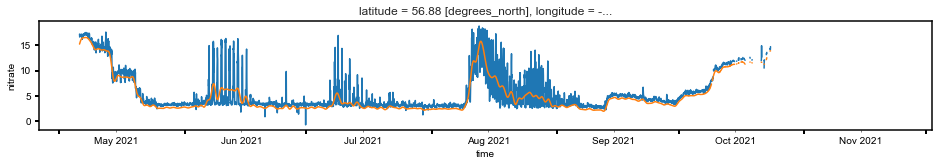

In [7]:
#wrap the plot in image settings for visual appeal
# may be able to make this cleaner or just a preset
# copy is in the notebook examples
%run '../../settings/mpl_plot_settings.py'

%matplotlib inline
import matplotlib.dates as mdates
from matplotlib.dates import YearLocator, WeekdayLocator, MonthLocator, DayLocator, HourLocator, DateFormatter
import matplotlib.ticker as ticker

fig, ax = plt.subplots(1,figsize=(16, 2))
suna_wop_nc_qc_orig['nitrate'].plot(ax=ax)
((suna_wop_nc_qc[var_choice][:,0,0,0] * 0) + lanzcosfiltered).plot(label='f35',ax=ax)

ax.xaxis.set_major_locator(DayLocator(bymonthday=1))
ax.xaxis.set_minor_locator(DayLocator(bymonthday=15))
ax.xaxis.set_minor_formatter(DateFormatter('%b %Y'))
ax.xaxis.set_major_formatter(DateFormatter(''))
ax.xaxis.set_tick_params(which='major', pad=3)
ax.xaxis.set_tick_params(which='minor', pad=5)



In [8]:
## to file
suna_wop_nc_qc[var_choice+'_f35'] = (suna_wop_nc_qc[var_choice][:,0,0,0] * 0) + lanzcosfiltered

suna_wop_nc_qc.to_dataframe().to_csv(user_data_dir+'working/'+filename.replace('.nc','_f35.csv'))